# Overview

Sparkify is a music streaming service like pandora and Spotify. With the help of data generated through the user activity on the app with other demographic information, we will try to identify customers who are likely to cancel their usage of the services and send them marketing campaigns to stop them from churning.
We will manipulate large and realistic datasets with Spark in this workspace to engineer relevant features for predicting churn.This workspace contains a tiny subset (128MB) of the full dataset available (12GB).

### As churn is an important problem to solve for any business, we will try to predict customer churn in advance through our models.

We expect an uneven class distribution, hence will be using F1 score as the performance metric.F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially with uneven class distribution. As we don't want to miss too many customers who are likely to churn whilst we don't want to target too much on those who are not likely to churn, F1 is a good metric as it would take into acocunt both these factors through precision and recall.

We will perform exploratory analysis, followed up by feature creation and training multiple classification models to predict churn in future.

The methodolgy will include following steps:

1. ETL
2. Define customer churn and EDA
3. Feature Engg.
4. Model pipeline set up
5. Evaluation - Train and Validation
6. Hypertuning Selected Model
7. Result - Train and Test
8. Analyzing the results








In [10]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull, row_number
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

import pyspark.sql.functions as F
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re

import datetime
from time import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify - workspace") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [12]:
# Read the mini file
event_data = "mini_sparkify_event_data.json"
df = spark.read.json(event_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [13]:
df.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [14]:
df.count(), len(df.columns)

(286500, 18)

In [15]:
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [16]:
# Investiagte UserID
df.select('userId').distinct().sort('userId').show(3)
# Investiagte sessionId
df.select('sessionId').distinct().sort('sessionId').show(3)

+------+
|userId|
+------+
|      |
|    10|
|   100|
+------+
only showing top 3 rows

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
+---------+
only showing top 3 rows



In [17]:
# drop records with blank userId
df = df.filter(df.userId!="")
df.count()

278154

# Exploratory Data Analysis
Perform EDA on the data using Spark. 

### Define Churn

A churned customer is defined as someone who has `Cancellation Confirmation` event, which happen for both paid and free users.

### Explore Data
We will perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned

In [18]:
# Exploring page 
df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [19]:
# Number of users who cancelled subscription
df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().count()


52

In [20]:
df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(5)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
+------+
only showing top 5 rows



In [21]:
# add a time column to df
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn('event_time', convert_ts('ts'))
df = df.withColumn('registration_time', convert_ts('registration'))

In [22]:
df.select(["userId", "page", "event_time", "level", "song", "sessionId"]).where(df.userId == "125").sort("event_time").show()

+------+--------------------+-------------------+-----+--------------------+---------+
|userId|                page|         event_time|level|                song|sessionId|
+------+--------------------+-------------------+-----+--------------------+---------+
|   125|            NextSong|2018-10-12 04:05:44| free|    paranoid android|      174|
|   125|            NextSong|2018-10-12 04:11:21| free|Hypnotize(Album V...|      174|
|   125|            NextSong|2018-10-12 04:15:11| free|       I'm On My Way|      174|
|   125|            NextSong|2018-10-12 04:18:34| free|Leader Of Men (Al...|      174|
|   125|            NextSong|2018-10-12 04:22:04| free|       Love You Down|      174|
|   125|            NextSong|2018-10-12 04:28:35| free|Don't Leave Me Be...|      174|
|   125|            NextSong|2018-10-12 04:32:08| free|     They're Red Hot|      174|
|   125|            NextSong|2018-10-12 04:35:06| free|                Kota|      174|
|   125|         Roll Advert|2018-10-12 04:

In [23]:
# create churn label
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df_event = df.withColumn('churn_event', churn_event('page'))

# label user who churned
windowval = Window.partitionBy('userId')
df_event = df_event.withColumn('churn', max('churn_event').over(windowval))

In [24]:
df_event.select(["userId", "page", "event_time", "level", "song", "sessionId","churn", "churn_event"]).where(df.userId == "125").sort("event_time").show()

+------+--------------------+-------------------+-----+--------------------+---------+-----+-----------+
|userId|                page|         event_time|level|                song|sessionId|churn|churn_event|
+------+--------------------+-------------------+-----+--------------------+---------+-----+-----------+
|   125|            NextSong|2018-10-12 04:05:44| free|    paranoid android|      174|    1|          0|
|   125|            NextSong|2018-10-12 04:11:21| free|Hypnotize(Album V...|      174|    1|          0|
|   125|            NextSong|2018-10-12 04:15:11| free|       I'm On My Way|      174|    1|          0|
|   125|            NextSong|2018-10-12 04:18:34| free|Leader Of Men (Al...|      174|    1|          0|
|   125|            NextSong|2018-10-12 04:22:04| free|       Love You Down|      174|    1|          0|
|   125|            NextSong|2018-10-12 04:28:35| free|Don't Leave Me Be...|      174|    1|          0|
|   125|            NextSong|2018-10-12 04:32:08| free|

In [25]:
# checking the number of churners are same as cancelled confirmation
df_event.filter(df_event.churn_event==1).select("userId").dropDuplicates().count()

52

Text(0.5,1,'Male customers are slightly likely to churn')

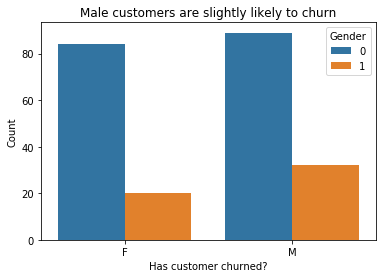

In [26]:
# Exploring gender distribution for the two cohorts
df_gender=df_event.groupby(["userId", "gender"]).max("churn").withColumnRenamed("max(churn)", "churn").select(["userId","gender", "churn"]).toPandas()

sns.countplot(x="gender", hue="churn", data=df_gender)
plt.xlabel('Has customer churned?')
plt.ylabel('Count')
plt.legend(title='Gender', loc='best')
plt.title('Male customers are slightly likely to churn')

Text(0.5,1,'Free customers are slightly likely to churn')

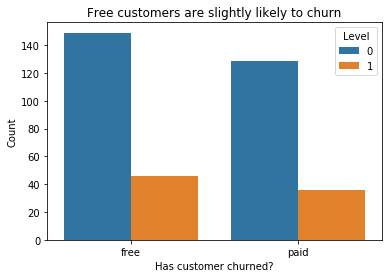

In [27]:
# Exploring free/paid for the two cohorts
df_level=df_event.groupby(["userId", "level"]).max("churn").withColumnRenamed("max(churn)", "churn").select(["userId","level", "churn"]).toPandas()

sns.countplot(x="level", hue="churn", data=df_level)
plt.xlabel('Has customer churned?')
plt.ylabel('Count')
plt.legend(title='Level', loc='best')
plt.title('Free customers are slightly likely to churn')

In [28]:
# Look at a userId sample

df_event.select(["userId", "page", "event_time", "level", "song", "sessionId","churn", 'registration','ts']).where(df.userId == "125").sort("event_time").show()

+------+--------------------+-------------------+-----+--------------------+---------+-----+-------------+-------------+
|userId|                page|         event_time|level|                song|sessionId|churn| registration|           ts|
+------+--------------------+-------------------+-----+--------------------+---------+-----+-------------+-------------+
|   125|            NextSong|2018-10-12 04:05:44| free|    paranoid android|      174|    1|1533157139000|1539317144000|
|   125|            NextSong|2018-10-12 04:11:21| free|Hypnotize(Album V...|      174|    1|1533157139000|1539317481000|
|   125|            NextSong|2018-10-12 04:15:11| free|       I'm On My Way|      174|    1|1533157139000|1539317711000|
|   125|            NextSong|2018-10-12 04:18:34| free|Leader Of Men (Al...|      174|    1|1533157139000|1539317914000|
|   125|            NextSong|2018-10-12 04:22:04| free|       Love You Down|      174|    1|1533157139000|1539318124000|
|   125|            NextSong|201

Text(0.5,1,'Customers with lower lifetime are more likely to churn')

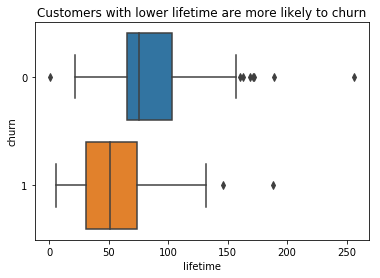

In [29]:
# Exploring lifetime value for the two cohorts
df_lifetime = df_event.select('userId','registration','ts','churn').withColumn('lifetime',(df_event.ts-df_event.registration)) \
    .groupBy('userId','churn').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')).toPandas()

sns.boxplot(x='lifetime', y='churn', orient="h", data=df_lifetime)
plt.title('Customers with lower lifetime are more likely to churn')

Text(0.5,1,'Customers who listen to less artists are more likely to churn')

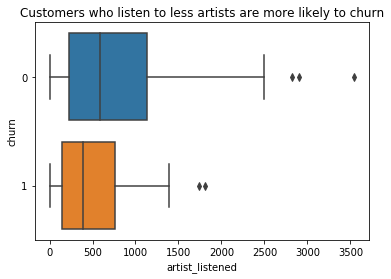

In [30]:
# Exploring no of artists listened by the two cohorts# 
df_artists = df_event.dropDuplicates(["userId", "artist"]).select('userId','artist','churn').groupBy('userId','churn').agg({'artist':'count'}).withColumnRenamed('count(artist)','artist_listened') \
    .select('userId', 'churn', 'artist_listened').toPandas()

sns.boxplot(x='artist_listened', y='churn', orient="h", data=df_artists)
plt.title('Customers who listen to less artists are more likely to churn')

Text(0.5,1,'Customers logging to less sessions are more likely to churn')

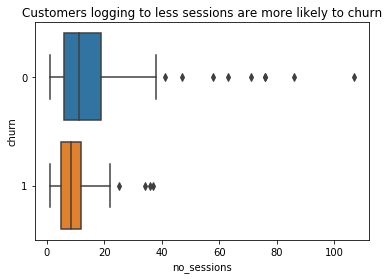

In [31]:
# Exploring sessions used by the two cohorts
df_sessions = df_event.dropDuplicates(["userId", "sessionId"]).select('userId','sessionId','churn').groupBy('userId','churn').agg({'sessionId':'count'}).withColumnRenamed('count(sessionId)','no_sessions') \
    .select('userId', 'churn', 'no_sessions').toPandas()

sns.boxplot(x='no_sessions', y='churn', orient="h", data=df_sessions)
plt.title('Customers logging to less sessions are more likely to churn')

Text(0.5,1,'Customers giving less thumps up are more likely to churn')

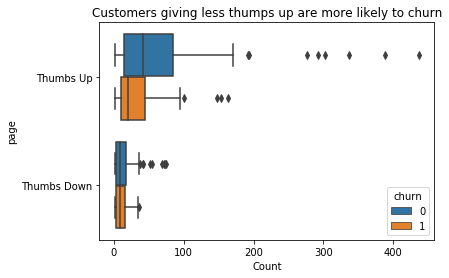

In [32]:
# Exploring positive and negative views for the two cohorts
df_thumps_count = df_event.where('page == "Thumbs Down" OR page == "Thumbs Up"').select('userId','page','churn').groupBy('userId','page','churn').agg({'page':'count'}).withColumnRenamed('count(page)','Count') \
    .select('userId', 'churn','page', 'Count').toPandas()
sns.boxplot(x='Count', y='page', hue= 'churn', orient="h", data=df_thumps_count)
plt.title('Customers giving less thumps up are more likely to churn')

In [33]:
# Day wise distribution
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df_event = df_event.withColumn("weekday", get_weekday(df_event.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_event = df_event.withColumn("day", get_day(df_event.ts))


In [34]:
df_weekday = df_event.filter(df_event.page == "NextSong").groupby("churn", "weekday").count().orderBy(df_event["weekday"].cast("float")).toPandas()
df_weekday["weekday"] = pd.to_numeric(df_weekday["weekday"])

df_day = df_event.filter(df_event.page == "NextSong").groupby("churn", "day").count().orderBy(df_event["day"].cast("float")).toPandas()
df_day["day"] = pd.to_numeric(df_day["day"])

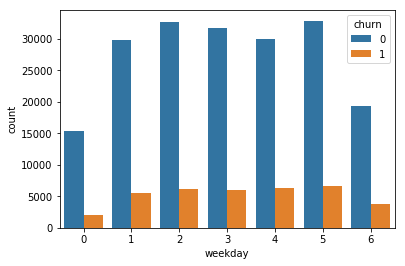

In [35]:
sns.barplot(x='weekday', y='count', hue= 'churn', data=df_weekday)

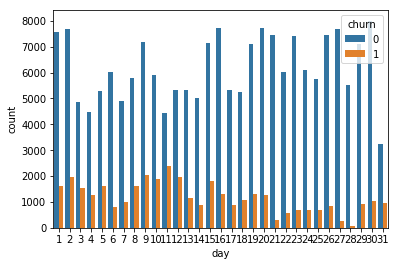

In [36]:
sns.barplot(x='day', y='count', hue= 'churn', data=df_day)

# Feature Engineering

As we have familiarized with the data through the exploratory anaysis, time to derive necessary features which can be used to train the model to predict churn.

The category of features derived are:
 - Days in System
 - Songs related
 - Artist related
 - Session related
 - Activity on page related
 - Demographic (Gender)
 - Experience related (Thumps up and Down)
 
 We will be deriving more features based on the above features at the end of this section


In [37]:
# Get days in system
days = df_event.groupby('userId').agg(((max(col('ts')) - min(col('registration')))/86400000).alias("Days"))
days.describe().show()

+-------+------------------+-------------------+
|summary|            userId|               Days|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



In [38]:
# Get total number of songs played
no_songs=df_event.where(col('song')!='null').groupby("userId").agg({'song':'count'}).withColumnRenamed('count(song)','no_songs').orderBy('userId')
no_songs.describe().show()

# # Get unique number of songs listened
no_unique_songs=df_event.dropDuplicates(["userId", "song"]).where(col('song')!='null').groupby("userId").agg({'song':'count'}).withColumnRenamed('count(song)','no_unique_songs').orderBy('userId')
no_unique_songs.describe().show()

# Get number of songs per session
no_songs_session=df_event.where(col('song')!='null').groupby("userId", "sessionId").count()
avg_songs_session=no_songs_session.groupby("userId").agg({'count':'avg'}).withColumnRenamed('avg(count)','avg_songs_session').orderBy('userId')
avg_songs_session.describe().show()

+-------+------------------+------------------+
|summary|            userId|          no_songs|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|1013.8133333333334|
| stddev| 105396.4779190716|1104.9607785540882|
|    min|                10|                 3|
|    max|                99|              8002|
+-------+------------------+------------------+

+-------+------------------+-----------------+
|summary|            userId|  no_unique_songs|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|897.7911111111111|
| stddev| 105396.4779190716| 896.387604455034|
|    min|                10|                3|
|    max|                99|             5946|
+-------+------------------+-----------------+

+-------+------------------+-----------------+
|summary|            userId|avg_songs_session|
+-------+------------------+-----------------+
| 

In [39]:
# Get number of unique artists listened
no_unique_artist=df_event.dropDuplicates(["userId", "artist"]).where(col('artist')!='null').groupby("userId").agg({'artist':'count'}).withColumnRenamed('count(artist)','no_unique_artist').orderBy('userId')
no_unique_artist.describe().show()

+-------+------------------+-----------------+
|summary|            userId| no_unique_artist|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev| 105396.4779190716|603.9518698630806|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+



In [40]:
# Get No of thumps up and thumps down
thumps_up = df_event.select('userID','page').where(df_event.page == 'Thumbs Up').groupBy('userID').count().withColumnRenamed('count', 'num_thumb_up') 
thumps_up.describe().show()

thumps_down = df_event.select('userID','page').where(df_event.page == 'Thumbs Down').groupBy('userID').count().withColumnRenamed('count', 'num_thumb_down') 
thumps_down.describe().show()


+-------+------------------+-----------------+
|summary|            userID|     num_thumb_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+

+-------+------------------+------------------+
|summary|            userID|    num_thumb_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [41]:
# Get  No of sessions
no_sessions=df_event.dropDuplicates(["userId", "sessionId"]).groupby("userId").count().withColumnRenamed('count', 'no_sessions')
no_sessions.describe().show()

# get avg time spent per session
session_time= df_event.groupby('userId', "sessionId").agg(((max(df_event.ts)-min(df_event.ts))/(1000*60)).alias("sessionTime"))
session_time_stat = session_time.groupby("userId").agg(avg(session_time.sessionTime).alias("avgSessionTime"), min(session_time.sessionTime).alias("minSessionTime"), max(session_time.sessionTime).alias("maxSessionTime")).sort("userId")
session_time_stat.describe().show()

+-------+------------------+------------------+
|summary|            userId|       no_sessions|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|14.115555555555556|
| stddev|105396.47791907164|14.646884657111562|
|    min|                10|                 1|
|    max|                99|               107|
+-------+------------------+------------------+

+-------+------------------+------------------+-----------------+-----------------+
|summary|            userId|    avgSessionTime|   minSessionTime|   maxSessionTime|
+-------+------------------+------------------+-----------------+-----------------+
|  count|               225|               225|              225|              225|
|   mean|65391.013333333336|288.16598407334976| 36.1317777777778|968.0325185185189|
| stddev| 105396.4779190716|176.84244472357116|90.64909420429709|723.3177369502857|
|    min|                10|               7.0|              0.

In [42]:
#  Get songs added to playlist
no_songs_playlist = df_event.select('userID','page').where(df_event.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'add_to_playlist')
no_songs_playlist.describe().show()
# Get friends added
no_friends_added = df_event.select('userID','page').where(df_event.page == 'Add Friend').groupBy('userID').count().withColumnRenamed('count', 'friends_added')
no_friends_added.describe().show()

+-------+------------------+-----------------+
|summary|            userID|  add_to_playlist|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+

+-------+------------------+------------------+
|summary|            userID|     friends_added|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



In [43]:
# get length of songs listened to
total_length_listened=df_event.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'time_music_listened')
total_length_listened.describe().show()


+-------+------------------+-------------------+
|summary|            userID|time_music_listened|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 252558.32065155543|
| stddev|105396.47791907164|  275396.4038847635|
|    min|                10|          691.66884|
|    max|                99| 1991154.9155799907|
+-------+------------------+-------------------+



In [44]:
# Gender flag

gender_flag = df_event.select("userId", "gender").dropDuplicates().replace(["M", "F"], ["0", "1"], "gender").select("userId", "gender")

gender_flag = gender_flag.select("userID",gender_flag.gender.cast("int"))
gender_flag.describe().show()


+-------+------------------+-------------------+
|summary|            userID|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [45]:
window = Window.partitionBy("userId").orderBy("userId", desc("ts"))

df_new=df_event.withColumn("rank", row_number().over(window))
user_level=df_new.select(["userId",  "level"]).where(df_new.rank == 1)

user_level= user_level.replace(["free", "paid"], ["0", "1"], "level")
user_level = user_level.select("userId", user_level.level.cast("int"))
user_level.describe().show()

+-------+------------------+------------------+
|summary|            userId|             level|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.6444444444444445|
| stddev|105396.47791907164|0.4797486114192829|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [46]:
# create the churn label
user_churn = df_event.select("userId", "churn").dropDuplicates()
user_churn = user_churn.select("userId", user_churn.churn.cast("int"))
user_churn.describe().show()

+-------+------------------+------------------+
|summary|            userId|             churn|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [47]:
# Get all the features together
data_final = days.join(no_songs,'userID','outer') \
    .join(no_unique_songs,'userID','outer') \
    .join(avg_songs_session,'userID','outer') \
    .join(no_unique_artist,'userID','outer') \
    .join(thumps_up,'userID','outer') \
    .join(thumps_down,'userID','outer') \
    .join(no_sessions,'userID','outer') \
    .join(session_time_stat,'userID','outer') \
    .join(no_songs_playlist,'userID','outer') \
    .join(no_friends_added,'userID','outer') \
    .join(total_length_listened,'userID','outer') \
    .join(gender_flag,'userID','outer') \
    .join(user_level,'userID','outer') \
    .join(user_churn,'userID','outer') \
    .drop('userID') \
    .fillna(0)


In [48]:
data_final.show(5)

+------------------+--------+---------------+------------------+----------------+------------+--------------+-----------+------------------+------------------+------------------+---------------+-------------+-------------------+------+-----+-----+
|              Days|no_songs|no_unique_songs| avg_songs_session|no_unique_artist|num_thumb_up|num_thumb_down|no_sessions|    avgSessionTime|    minSessionTime|    maxSessionTime|add_to_playlist|friends_added|time_music_listened|gender|level|churn|
+------------------+--------+---------------+------------------+----------------+------------+--------------+-----------+------------------+------------------+------------------+---------------+-------------+-------------------+------+-----+-----+
| 55.64365740740741|     275|            269|39.285714285714285|             252|          17|             5|          7|154.48333333333332|             22.55|             323.0|              7|            4|  66940.89735000003|     1|    0|    0|
| 70.074

In [49]:
# Creating some more derived fields
data_final=data_final.withColumn("songs_per_day", (F.col("no_songs") / F.col("Days")))
data_final=data_final.withColumn("songs_per_session", (F.col("no_songs") / F.col("no_sessions")))
data_final=data_final.withColumn("thumps_up_per_session", (F.col("num_thumb_up") / F.col("no_sessions")))
data_final=data_final.withColumn("thumps_down_per_session", (F.col("num_thumb_down") / F.col("no_sessions")))

# Modeling

In this section, we will do the following
    - Feature preprocessing
    - Split into train, validation and test
    - Train Logistic, Decision Tree and GBT Classifier 
    - Use Cross validation with F1 as accuracy metric
    - Used the trained models on the validation data
    - Winning model from the three algorithm with best results
    - Hypertune the selected model parameters
    - Report the result on test data
    

In [50]:
# features of the final data
data_final.persist()

DataFrame[Days: double, no_songs: bigint, no_unique_songs: bigint, avg_songs_session: double, no_unique_artist: bigint, num_thumb_up: bigint, num_thumb_down: bigint, no_sessions: bigint, avgSessionTime: double, minSessionTime: double, maxSessionTime: double, add_to_playlist: bigint, friends_added: bigint, time_music_listened: double, gender: int, level: int, churn: int, songs_per_day: double, songs_per_session: double, thumps_up_per_session: double, thumps_down_per_session: double]

In [51]:
# Churn distribution 
data_final.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [52]:
# Vector Assembler
cols=['Days', 'no_songs', 'no_unique_songs', 'avg_songs_session', 'no_unique_artist', 'num_thumb_up', 'num_thumb_down', 
      'no_sessions', 'avgSessionTime', 'minSessionTime', 'maxSessionTime', 'add_to_playlist', 'friends_added', 'time_music_listened',
     'gender', 'level',  'songs_per_day', 'songs_per_session', 'thumps_up_per_session', 'thumps_down_per_session'] 
assembler=VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data_features = assembler.transform(data_final)

In [53]:
data_features.collect()

[Row(Days=55.64365740740741, no_songs=275, no_unique_songs=269, avg_songs_session=39.285714285714285, no_unique_artist=252, num_thumb_up=17, num_thumb_down=5, no_sessions=7, avgSessionTime=154.48333333333332, minSessionTime=22.55, maxSessionTime=323.0, add_to_playlist=7, friends_added=4, time_music_listened=66940.89735000003, gender=1, level=0, churn=0, songs_per_day=4.9421625538833, songs_per_session=39.285714285714285, thumps_up_per_session=2.4285714285714284, thumps_down_per_session=0.7142857142857143, NumFeatures=DenseVector([55.6437, 275.0, 269.0, 39.2857, 252.0, 17.0, 5.0, 7.0, 154.4833, 22.55, 323.0, 7.0, 4.0, 66940.8974, 1.0, 0.0, 4.9422, 39.2857, 2.4286, 0.7143])),
 Row(Days=70.07462962962963, no_songs=387, no_unique_songs=378, avg_songs_session=64.5, no_unique_artist=339, num_thumb_up=21, num_thumb_down=6, no_sessions=6, avgSessionTime=266.40000000000003, minSessionTime=12.1, maxSessionTime=497.45, add_to_playlist=8, friends_added=4, time_music_listened=94008.87593999993, gen

In [54]:
# standard scaler
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data_features)
data_features = scalerModel.transform(data_features)

In [55]:
data_features.collect()

[Row(Days=55.64365740740741, no_songs=275, no_unique_songs=269, avg_songs_session=39.285714285714285, no_unique_artist=252, num_thumb_up=17, num_thumb_down=5, no_sessions=7, avgSessionTime=154.48333333333332, minSessionTime=22.55, maxSessionTime=323.0, add_to_playlist=7, friends_added=4, time_music_listened=66940.89735000003, gender=1, level=0, churn=0, songs_per_day=4.9421625538833, songs_per_session=39.285714285714285, thumps_up_per_session=2.4285714285714284, thumps_down_per_session=0.7142857142857143, NumFeatures=DenseVector([55.6437, 275.0, 269.0, 39.2857, 252.0, 17.0, 5.0, 7.0, 154.4833, 22.55, 323.0, 7.0, 4.0, 66940.8974, 1.0, 0.0, 4.9422, 39.2857, 2.4286, 0.7143]), features=DenseVector([1.4775, 0.2489, 0.3001, 0.9219, 0.4173, 0.2596, 0.3823, 0.4779, 0.8736, 0.2488, 0.4466, 0.214, 0.1943, 0.2431, 2.0013, 0.0, 0.3098, 0.9283, 1.0442, 1.2109])),
 Row(Days=70.07462962962963, no_songs=387, no_unique_songs=378, avg_songs_session=64.5, no_unique_artist=339, num_thumb_up=21, num_thumb_

In [56]:
# train test split
data_features = data_features.select(data_features.churn.alias("label"), data_features.features)
train, rest = data_features.randomSplit([0.7, 0.3], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

### Training a Logistic Classifier

In [57]:
# initialize classifier
lr = LogisticRegression(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)
cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics

[0.7936830186946545]

In [58]:
results_lr = cvModel_lr.transform(validation)

### Training a Decision Tree Classifier

In [59]:
dt = DecisionTreeClassifier()

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_dt = CrossValidator(estimator=dt,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

cvModel_dt = crossval_dt.fit(train)
cvModel_dt.avgMetrics

[0.7558949237670758]

In [60]:
results_dt = cvModel_dt.transform(validation)

### Training a GB Classifier

In [61]:
gbt = GBTClassifier(maxIter=10)

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_gbt = CrossValidator(estimator=gbt,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics

[0.7484432559380495]

In [62]:
results_gbt = cvModel_gbt.transform(validation)

### Comparing the F1 result on the validation data

In [63]:
def stats(results):
    tp = results.filter("label = 1 and prediction = 1").count()
    fp = results.filter("label = 0 and prediction = 1").count()
    fn = results.filter("label = 1 and prediction = 0").count()
    precision = tp / (tp + fp) 
    recall = tp / (tp + fn)
    f1 = 2*precision*recall / (precision+recall)
    return f1

In [64]:
print('F-1 Score for Logistic Model:{}'.format(stats(results_lr)))
print('F-1 Score for DT Model:{}'.format(stats(results_dt)))
print('F-1 Score for GBT Model:{}'.format(stats(results_gbt)))

F-1 Score for Logistic Model:0.25
F-1 Score for DT Model:0.6
F-1 Score for GBT Model:0.6


### Model Summary Results:

    -  Logistic Classifier gives a F1 score of 0.79 on train data and 0.25 on validation data
    -  DT Classifier gives a F1 score of 0.75 on train data and 0.60 on validation data
    -  GB Classifier gives a F1 score of 0.74 on train data and 0.60 on validation data
    
I am going to use GB classifier for hypertuning and getting the results on test data. The result of DT classifier are identical and I could have used that as well. My decision is based on the asusmpion that GB might give better results for uneven class distribution.

Also, just to remind that we are using a mini sample of the data hence the result might change if we use the entire 12Gb of data

In [65]:
gbt_selected = GBTClassifier(maxIter=10)

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10]) \
    .addGrid(gbt.maxDepth,[4, 8]) \
    .build()

crossval_gbt_selected = CrossValidator(estimator=gbt_selected,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

cvModel_gbt_selected = crossval_gbt_selected.fit(train)
cvModel_gbt_selected.avgMetrics

[0.7484432559380495,
 0.7484432559380495,
 0.7484432559380495,
 0.7484432559380495]

In [69]:
results_gbt_best = cvModel_gbt_selected.transform(test)

In [70]:
print('F-1 Score for Best GBT Model:{}'.format(stats(results_gbt_best)))

F-1 Score for Best GBT Model:0.4


In [76]:
cvModel_gbt_selected.bestModel.featureImportances

SparseVector(20, {0: 0.2618, 1: 0.0455, 3: 0.0209, 5: 0.0084, 6: 0.1013, 7: 0.0648, 8: 0.01, 9: 0.0807, 10: 0.0251, 11: 0.0324, 12: 0.07, 13: 0.0039, 14: 0.0072, 15: 0.0053, 16: 0.0411, 17: 0.0038, 18: 0.07, 19: 0.1478})

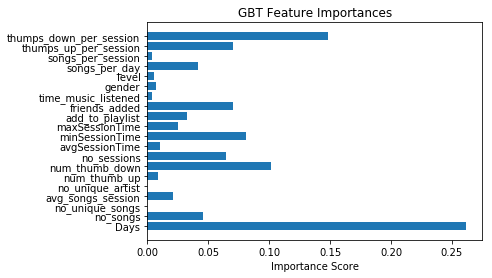

In [77]:
# Getting the important features
feat_imp = cvModel_gbt_selected.bestModel.featureImportances
y_pos = np.arange(len(cols))
 
plt.barh(y_pos, feat_imp, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances');


Looking at the feature importance we can see Days( Days on system) is coming out to be the most important variable. This was also highlighted in the exploratory section where we found customers who are less tenured on sparkify are more likely to churn.
Other features like thumps down per session, friends added and min session time are also coming out to be important feature. Customer who give more thumps down per session are not happy with the content they are seeing and are more likely to churn. Customer adding friend is a healthy sign for customer retention.


# Conclusion

## Reflection

This project exposed us to manipulate large and realistic datasets with Spark to engineer relevant features for predicting churn. While working with large dataset, we would need the capabilties of spark to handle the data.

One of key learning is a ML project is not just about training a model but equally is about uderstanding the business context, defining the target and deriving key features after exploring the data to get a good model.

Athough, the data used here is small but training GBC took lot of time in the workspace. To handle more volume of data, we would have to move outside workspace and need to use IBM or AWS environment.

## Improvement

Although we used Spark to train the mini data in this project but the result could be furthur improved if we can have more data to train our model on. Presently, we used just 225 customers data out of which 52 churned(23%).
Working a high level calculation gives me that in the full data with total data size of 12gb, we will have ~21000 customers activity recorded. Using all of the data can make a lot of difference in the results.
